# Transfer Learning:
“Instead of training a model from scratch, we take a pre-trained model (a model that already learned a lot from a huge dataset like ImageNet) and use it for our own task — like recognizing fashion items.

## VGG-19

- A deep model with 19 layers.
- It learns by stacking simple blocks of layers.
- Good at finding patterns like edges, shapes, etc.

## ResNet50
- A deeper model with 50 layers.
- Uses shortcut connections (residuals) so it doesn’t forget old things when learning new ones.
- More powerful and efficient for large image tasks.

In [38]:
# Importing Necessary Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow
from tensorflow import keras
from tensorflow.keras import layers, models, Input
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.applications import vgg19, resnet50
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, classification_report

import json
import os
import cv2
import subprocess
import requests


In [39]:
# Setting random state
tensorflow.random.set_seed(42)

## 1. Splitting ( Train and Test )

In [40]:
# Loading our dataset and splitting for training and testing
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


In [41]:
# Checking the shape and datatyopeof the testing and training data
print("Training Image :", train_images.shape, train_images.dtype)
print("Testing Image :", test_images.shape, test_images.dtype)

# It's a grayscale image wit channel 1

Training Image : (60000, 28, 28) uint8
Testing Image : (10000, 28, 28) uint8


In [42]:
# We will define the classes
classes = ['T-shirt/top', 'Trouser', 'Pullover',
           'Dress', 'Coat','Sandal', 'Shirt',
           'Sneaker', 'Bag', 'Ankle boot']


## 2. Adding Channels

In [43]:
# Checking shape of training and testing data
print(train_images.shape)
print(test_images.shape)


(60000, 28, 28)
(10000, 28, 28)


In [44]:
# In order to make vgg19 and renet50 work, we need the images in 3 channels.
train_images = np.repeat(train_images[..., np.newaxis], 3, axis=-1)
test_images = np.repeat(test_images[..., np.newaxis], 3, axis=-1)


In [45]:
# Checking shape again
print(train_images.shape, train_images.dtype)
print(test_images.shape, test_images.dtype)


(60000, 28, 28, 3) uint8
(10000, 28, 28, 3) uint8


## 3. Resizing Images

In [46]:
# Resize safely one-by-one
train_images = np.array([cv2.resize(img, (32, 32)) for img in train_images])
test_images = np.array([cv2.resize(img, (32, 32)) for img in test_images])

# Printing the shape to check again
print(train_images.shape, train_images.dtype)
print(test_images.shape, test_images.dtype)


(60000, 32, 32, 3) uint8
(10000, 32, 32, 3) uint8


## 4. Normalization of Pixel Values

In [47]:
# Will change the pixel values to float
# # Dividing by 255.0 changes the pixel values to be between 0 and 1.
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0


In [48]:
# Printing the shape to check again
print(train_images.shape, train_images.dtype)
print(test_images.shape, test_images.dtype)


(60000, 32, 32, 3) float32
(10000, 32, 32, 3) float32


# 5. VGG19 Model Building

In [49]:
# Building Vgg19 Model
# weights='imagenet': Model already knows a lot because it was trained on a huge collection of pictures called ImageNet.
# include_top=False: Don’t want the last part of the model (that makes the final decision), we will add our own.
vgg = vgg19.VGG19(weights='imagenet', include_top=False,
input_shape= (32, 32, 3))


## 6. Model Summary

In [50]:
# Checking the summary of our model
vgg.summary()


Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

## 7. CNN - Top of VGG19

In [51]:
model = models.Sequential([
    # Step 1: Add the VGG19 base model (pre-trained, learns image features)
    vgg,

    # Step 2: Flatten - convert VGG19's 3D output to 1D for dense layers
    layers.Flatten(),

    # Step 3: First dense layer with 256 neurons, 'relu' helps learn complex patterns
    layers.Dense(256, activation='relu'),

    # Step 4: Dropout - randomly turn off 30% neurons during training to avoid overfitting
    layers.Dropout(0.3),

    # Step 5: Second dense layer with 256 neurons, also with 'relu'
    layers.Dense(256, activation='relu'),

    # Step 6: Another dropout layer to reduce overfitting
    layers.Dropout(0.3),

    # Step 7: Output layer with 10 neurons (for 10 classes), 'softmax' makes outputs probabilities
    layers.Dense(10, activation='softmax')

])


## 8. Model Summary - 2

In [52]:
# checking the summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 1, 1, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,224,074 (77.15 MB)

 Trainable params: 20,224,074 (77.15 MB)

 Non-trainable params: 0 (0.00 B)

## 9. Compiling Model

In [53]:
# Compiling our Model
history = model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)


## 10. Callback - Early Stopping

In [54]:
# patience=2 - Stop training early if validation loss doesn't improve for 2 epochs.
# monitor='val_loss' - Watching the validation loss (how bad the model is on test data it hasn’t seen)
# restore_best_weights=True - When stopping, keep the best version of the model you had during training.
earlyStop = EarlyStopping(patience = 2, monitor = 'val_loss', restore_best_weights = True)


## 11. Model Training

In [55]:
# Model Training
# verbose=1 gives a nice, detailed progress report while training!
history = model.fit(train_images, train_labels, epochs = 10, validation_split=0.1,
                    callbacks = [earlyStop], batch_size = 32, verbose = 1)


Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 138s 76ms/step - accuracy: 0.3837 - loss: 1.5842 - val_accuracy: 0.7385 - val_loss: 0.7619
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 131s 72ms/step - accuracy: 0.7365 - loss: 0.7188 - val_accuracy: 0.7872 - val_loss: 0.6086
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 122s 72ms/step - accuracy: 0.7894 - loss: 0.5924 - val_accuracy: 0.7990 - val_loss: 0.5577
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 142s 72ms/step - accuracy: 0.8060 - loss: 0.5379 - val_accuracy: 0.8238 - val_loss: 0.4708
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 142s 72ms/step - accuracy: 0.8400 - loss: 0.4550 - val_accuracy: 0.8573 - val_loss: 0.3905
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 142s 72ms/step - accuracy: 0.8628 - loss: 0.4317 - val_accuracy: 0.8753 - val_loss: 0.3444
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 143s 73ms/step - accuracy: 0.8824 - loss: 0.3546 - val_accuracy: 0.8680 - val_loss: 0.3583
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 141s 72ms/step - accuracy: 

## 12. Plot For Accuracy and Loss

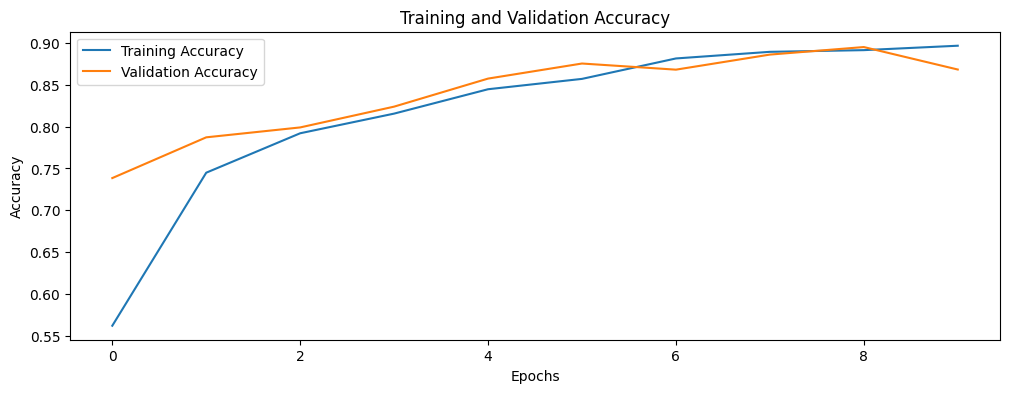

In [56]:
# Deciding the figure size for the plot
plt.figure(figsize=(12, 4))

# Making plot for accuracy
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')

# Deciding The labels and Title
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Adding legend
plt.legend()

# Showing plot
plt.show()


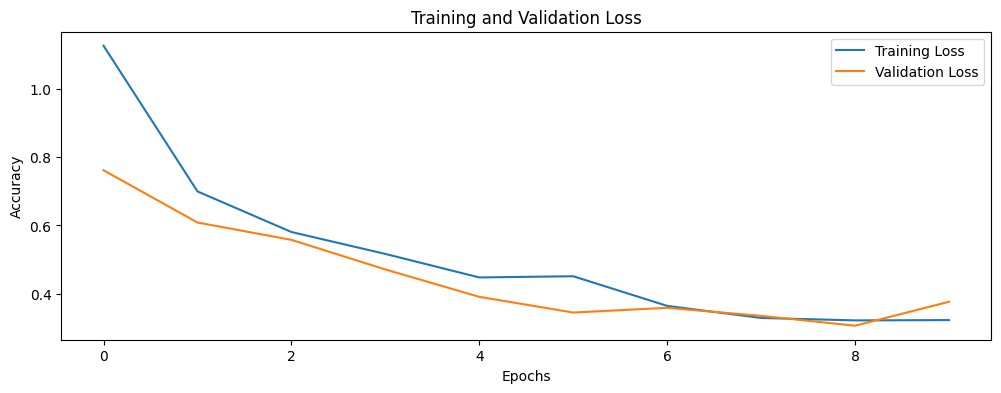

In [57]:
# Deciding the figure size for the plot
plt.figure(figsize=(12, 4))

# Making plot for loss
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')

# Deciding the labels and Title
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Adding legend
plt.legend()

# Showing plot
plt.show()


## 13. Model Prediction

In [58]:
# Prediction of model
predictions = model.predict(test_images)

# Checking first 5 predictions
predictions[:10]


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


array([[8.2838299e-11, 1.1957280e-10, 6.2668876e-10, 1.5074692e-12,
        3.7548237e-12, 2.4274619e-04, 4.4204189e-11, 4.3587787e-03,
        4.3870802e-08, 9.9539840e-01],
       [1.4637085e-04, 1.9143719e-08, 9.9563473e-01, 1.9178268e-07,
        2.6651754e-04, 6.6497209e-13, 3.9521568e-03, 1.6897838e-13,
        1.0489427e-09, 5.0460238e-13],
       [4.2284405e-23, 1.0000000e+00, 5.4126526e-31, 8.3381193e-16,
        8.7150179e-28, 1.9618179e-44, 4.8867765e-22, 1.4012985e-45,
        6.0914554e-33, 2.0118106e-39],
       [1.6721227e-18, 1.0000000e+00, 7.1456562e-27, 1.7537656e-12,
        6.2910395e-23, 1.5479041e-36, 5.9155160e-18, 4.7606266e-37,
        8.6657595e-27, 6.7391297e-33],
       [1.9152500e-01, 9.2583461e-05, 1.8166101e-02, 8.5209981e-03,
        6.8969750e-03, 4.9120345e-06, 7.7176964e-01, 8.1427225e-07,
        3.0198486e-03, 3.0319595e-06],
       [6.2020567e-18, 1.0000000e+00, 1.0756092e-23, 2.4292265e-12,
        1.2908481e-21, 3.0225011e-34, 4.2028838e-17, 2.83

In [59]:
# np.argmax(predictions, axis=1) - For each image, find the class with the highest score — picking the best guess.
prediction_labels = np.argmax (predictions, axis = 1)

# Getting the first 5 predicted class labels
prediction_labels[:10]


array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

## 14. Model Evaluation

In [60]:
# Evaluating Model
classification = classification_report(test_labels, prediction_labels, target_names = classes)
conMat = confusion_matrix(test_labels, prediction_labels)


In [61]:
# Printing the classification report and confusion Report
print( classification)
print()
pd.DataFrame(conMat, index= classes, columns = classes)


              precision    recall  f1-score   support

 T-shirt/top       0.78      0.88      0.83      1000
     Trouser       0.98      0.98      0.98      1000
    Pullover       0.86      0.84      0.85      1000
       Dress       0.84      0.92      0.88      1000
        Coat       0.78      0.85      0.82      1000
      Sandal       0.97      0.98      0.98      1000
       Shirt       0.77      0.56      0.64      1000
     Sneaker       0.94      0.98      0.96      1000
         Bag       0.98      0.97      0.98      1000
  Ankle boot       0.98      0.94      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000




,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,877,6,12,44,3,0,52,0,6,0
Trouser,2,980,0,17,0,0,0,0,1,0
Pullover,17,1,840,16,83,0,43,0,0,0
Dress,18,8,3,922,36,1,11,0,1,0
Coat,1,0,53,43,855,0,48,0,0,0
Sandal,0,0,0,0,1,979,0,9,2,9
Shirt,208,1,71,48,110,0,555,0,7,0
Sneaker,0,0,0,0,0,12,0,978,0,10
Bag,0,0,0,5,5,3,11,3,973,0
Ankle boot,0,0,0,0,0,12,1,46,0,941


# ResNet50

In [62]:
# Building ResNet50 Model
# weights='imagenet': Model already knows a lot because it was trained on a huge collection of pictures called ImageNet.
# include_top=False: Don’t want the last part of the model (that makes the final decision), we will add our own.
resnet = resnet50.ResNet50(weights='imagenet', include_top=False,
input_shape= (32, 32, 3))


## 1. Model Summary

In [63]:
# Checking the summary of our model
resnet.summary()


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 16, 16,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 16, 16,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

## 2. CNN - Top of ResNet50

In [64]:
model = models.Sequential([
    # Step 1: Add the ResNet50 base model (pre-trained, learns image features)
    resnet,

    # Step 2: Flatten - convert ResNet50's 3D output to 1D for dense layers
    layers.Flatten(),

    # Step 3: First dense layer with 256 neurons, 'relu' helps learn complex patterns
    layers.Dense(256, activation='relu'),

    # Step 4: Dropout - randomly turn off 30% neurons during training to avoid overfitting
    layers.Dropout(0.3),

    # Step 5: Second dense layer with 256 neurons, also with 'relu'
    layers.Dense(256, activation='relu'),

    # Step 6: Another dropout layer to reduce overfitting
    layers.Dropout(0.3),

    # Step 7: Output layer with 10 neurons (for 10 classes), 'softmax' makes outputs probabilities
    layers.Dense(10, activation='softmax')
])


## 3. Model Summary - 2

In [65]:
# checking the summary
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,180,618 (92.24 MB)

 Trainable params: 24,127,498 (92.04 MB)

 Non-trainable params: 53,120 (207.50 KB)

## 4. Compiling Model

In [66]:
# Compiling our Model
history = model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)


## 5. Callback - Early Stopping

In [67]:
# patience=2 - Stop training early if validation loss doesn't improve for 2 epochs.
# monitor='val_loss' - Watching the validation loss (how bad the model is on test data it hasn’t seen)
# restore_best_weights=True - When stopping, keep the best version of the model you had during training.
earlyStop = EarlyStopping(patience = 2, monitor = 'val_loss', restore_best_weights = True)


## 6. Model Training

In [68]:
# Model Training
# verbose=1 gives a nice, detailed progress report while training!
history = model.fit(train_images, train_labels, epochs = 10, validation_split=0.1,
                    callbacks = [earlyStop], batch_size = 32, verbose = 1)


Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 128s 46ms/step - accuracy: 0.7191 - loss: 0.9478 - val_accuracy: 0.1655 - val_loss: 15.0995
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 92s 29ms/step - accuracy: 0.7487 - loss: 0.7232 - val_accuracy: 0.7088 - val_loss: 0.8073
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 81s 28ms/step - accuracy: 0.8004 - loss: 0.5820 - val_accuracy: 0.8657 - val_loss: 0.3893
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - accuracy: 0.8516 - loss: 0.4332 - val_accuracy: 0.8233 - val_loss: 0.4872
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 82s 29ms/step - accuracy: 0.8527 - loss: 0.4413 - val_accuracy: 0.8812 - val_loss: 0.3452
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 81s 28ms/step - accuracy: 0.8730 - loss: 0.3739 - val_accuracy: 0.8562 - val_loss: 0.3911
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 47s 28ms/step - accuracy: 0.8462 - loss: 0.4585 - val_accuracy: 0.8825 - val_loss: 0.3550


## 7. Plot For Accuracy and Loss

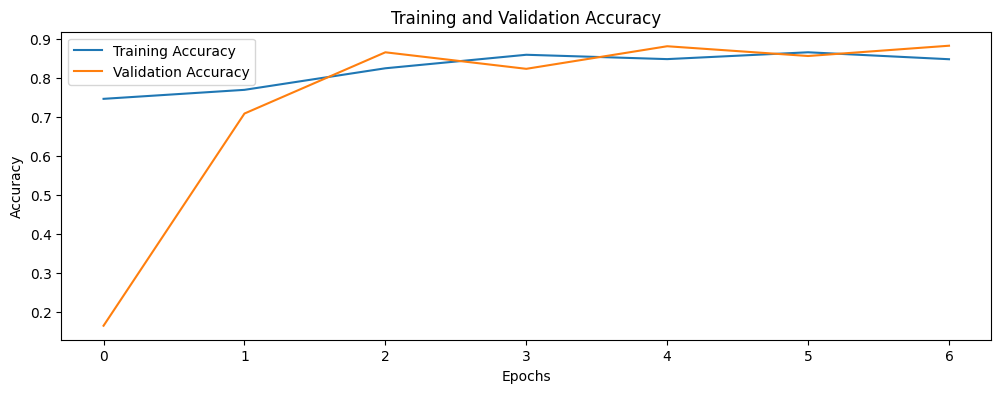

In [69]:
# Deciding the figure size for the plot
plt.figure(figsize=(12, 4))

# Making plot for accuracy
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')

# Deciding The labels and Title
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Adding legend
plt.legend()

# Showing plot
plt.show()


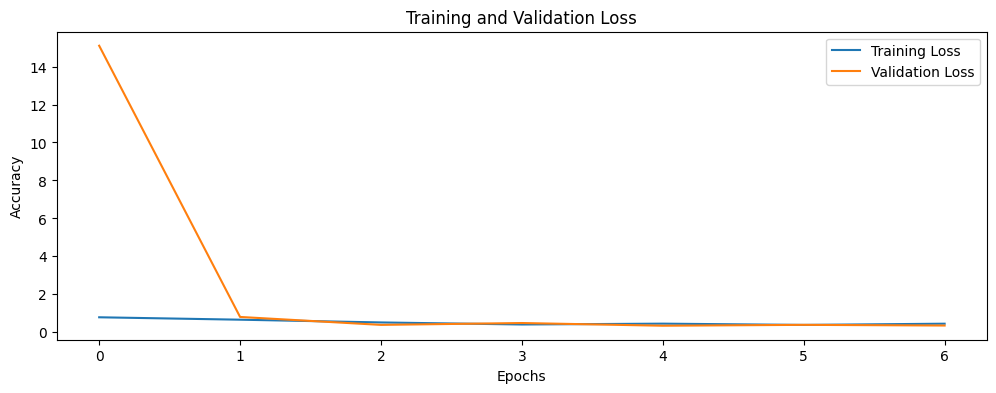

In [70]:
# Deciding the figure size for the plot
plt.figure(figsize=(12, 4))

# Making plot for loss
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')

# Deciding the labels and Title
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Adding legend
plt.legend()

# Showing plot
plt.show()


## 8. Model Prediction

In [71]:
# Prediction of model
predictions = model.predict(test_images)

# Checking first 5 predictions
predictions[:10]


313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step


array([[1.4170265e-09, 2.1927533e-10, 1.2448672e-09, 2.2346610e-08,
        3.8599013e-09, 8.3054509e-04, 1.7884670e-08, 1.1377964e-02,
        4.0899414e-07, 9.8779106e-01],
       [4.1200346e-05, 2.5340265e-08, 9.9683905e-01, 7.6211531e-06,
        2.9899266e-03, 5.5107501e-09, 1.2202256e-04, 6.9781829e-09,
        1.5793850e-07, 3.0168973e-08],
       [2.6018065e-09, 9.9999762e-01, 8.6214087e-08, 2.1088599e-06,
        2.7101935e-08, 2.8184196e-11, 7.9517200e-08, 8.5025546e-12,
        8.6210050e-10, 6.4011574e-12],
       [2.5091742e-09, 9.9999630e-01, 6.5921995e-08, 3.6320519e-06,
        2.6030454e-08, 2.5729016e-11, 5.5332706e-08, 8.2952759e-12,
        9.8936936e-10, 5.8296467e-12],
       [1.0910706e-01, 5.3461283e-03, 6.5059677e-02, 2.0606744e-01,
        1.8693846e-01, 1.8377518e-04, 4.2175078e-01, 1.4308229e-03,
        3.2793100e-03, 8.3652319e-04],
       [3.0338700e-09, 9.9999750e-01, 9.1251117e-08, 2.2656111e-06,
        3.4383582e-08, 2.2984455e-11, 9.0463999e-08, 8.41

In [72]:
# np.argmax(predictions, axis=1) - For each image, find the class with the highest score — picking the best guess.
prediction_labels = np.argmax (predictions, axis = 1)

# Getting the first 5 predicted class labels
prediction_labels[:10]

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

## 9. Model Evaluation

In [73]:
# Evaluating Model
classification = classification_report(test_labels, prediction_labels, target_names = classes)
conMat = confusion_matrix(test_labels, prediction_labels)

In [74]:
# Printing the classification report and confusion Report
print("Classification Report: ", classification)
print()
pd.DataFrame(conMat, index = classes, columns = classes)


Classification Report:                precision    recall  f1-score   support

 T-shirt/top       0.79      0.87      0.83      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.84      0.82      0.83      1000
       Dress       0.80      0.95      0.87      1000
        Coat       0.75      0.87      0.80      1000
      Sandal       0.99      0.94      0.96      1000
       Shirt       0.81      0.49      0.61      1000
     Sneaker       0.90      0.98      0.94      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.97      0.94      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.87     10000
weighted avg       0.88      0.88      0.87     10000




,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,866,3,14,73,4,1,33,0,6,0
Trouser,1,975,0,18,4,0,0,0,2,0
Pullover,14,0,818,19,106,0,43,0,0,0
Dress,8,2,1,946,31,0,11,0,1,0
Coat,2,2,56,46,871,0,21,0,2,0
Sandal,0,0,0,1,0,937,0,45,0,17
Shirt,201,1,82,72,143,0,489,0,12,0
Sneaker,0,0,0,0,0,5,0,976,3,16
Bag,2,1,1,4,7,2,4,7,972,0
Ankle boot,0,0,0,0,0,3,1,59,0,937
